In [1]:
import sklearn #for predictive modeling
from patsy import dmatrices #for R-like formulas. https://patsy.readthedocs.io/en/latest/
import seaborn as sns #for better graphics
sns.set() #better matplotlib defaults
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import requests

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None)

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,[11,35]], df.iloc[:,60]=='M')

# Question 1

In [8]:
#3,4 = .61
#1,8 = .76
#2,8 = .73
#2,1 = .71

layers = [
    (1,8), (4, 1), (2,1), (8,), (16,), (8, 4), (16, 8), (32, 16), (64, 32), (32,), (4, 4), (10, 10), (2,8)]
metric_names = ["ROC AUC", "Average Precision", "Accuracy"]
bestcombo = None
performance = 0 
for layer in layers:
    combined_score = 0
    model = MLPClassifier(solver='lbfgs', max_iter=6000, hidden_layer_sizes=layer, activation='logistic', alpha=0, random_state=0)
    print(f"Testing Performance of hidden layer combo: {layer}") 
    model.fit(X=X_train, y=y_train)
    for i, metric in enumerate([roc_auc_score, average_precision_score, accuracy_score]):
        print(f"{metric_names[i]}:  {metric(y_test, model.predict(X_test))}")
        combined_score += metric(y_test, model.predict(X_test))
    print("====================================================")
    if combined_score > performance:
        performance = combined_score
        best = layer
print(f"\n\nBest combined performance score: {performance}\nBest combo: {best}")

Testing Performance of hidden layer combo: (1, 8)
ROC AUC:  0.6118518518518519
Average Precision:  0.5851484238581013
Accuracy:  0.6153846153846154
Testing Performance of hidden layer combo: (4, 1)
ROC AUC:  0.5562962962962963
Average Precision:  0.5501628001628002
Accuracy:  0.5576923076923077
Testing Performance of hidden layer combo: (2, 1)
ROC AUC:  0.6118518518518519
Average Precision:  0.5851484238581013
Accuracy:  0.6153846153846154
Testing Performance of hidden layer combo: (8,)
ROC AUC:  0.6577777777777778
Average Precision:  0.6275946275946276
Accuracy:  0.6538461538461539
Testing Performance of hidden layer combo: (16,)
ROC AUC:  0.5762962962962963
Average Precision:  0.5627044423340719
Accuracy:  0.5769230769230769
Testing Performance of hidden layer combo: (8, 4)
ROC AUC:  0.7333333333333333
Average Precision:  0.6948160535117057
Accuracy:  0.7307692307692307
Testing Performance of hidden layer combo: (16, 8)
ROC AUC:  0.5562962962962963
Average Precision:  0.5501628001628

# Question 2

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import time

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Download data from open datasets. https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
sat_data = datasets.EuroSAT(
    root="data",
    download=True,
    transform=ToTensor(),
)

#label dictionary (taken from Kaggle link above)
label2int= sat_data.find_classes('data/eurosat/2750/')[1]
int2label = dict(zip(label2int.values(),label2int.keys()))

train_size =.8
test_size = .2
torch.manual_seed(0)
train_size = round(.8*len(sat_data))
training_data, testing_data = torch.utils.data.random_split(sat_data, [train_size, len(sat_data)-train_size])

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

In [4]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
# Download data from open datasets. https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*64*3, 1024), #(w x h x c, output_dim). nn.# Changing this to 1024 gave >11.0%
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Linear(256, 128), # ending in 64 gave 16.5% accuracy
            #nn.ReLU(),
            #nn.Linear(64, 32),
            #nn.ReLU(),
            #nn.Linear(256, 256), #adding this gave <11.0
            nn.ReLU(),
            nn.Linear(128, 10) #hidden layer of dimension 256 -> output layer of size 10 (the number of classes)
        )

    def forward(self, x):
        x = self.flatten(x) #flatten the 64 x 64 x 3 tensor to a 64*64*3 length tensor with 1 dimension.
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
#print(model)
loss_fn = nn.CrossEntropyLoss() #the appropriate loss function for multilabel problems.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Optimize the parameters of the models using SGD. Set the learning rate/step length.


def train(dataloader, model, loss_fn, optimizer): #a function to train the model
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # compute the gradient and take an SGD step.
        optimizer.zero_grad() 
        loss.backward() #MLers also call computing the gradient "back propagation". Hence the "backward()" function to compute the gradient
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test(dataloader, model, loss_fn): #a function to compute the testing loss
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    

torch.manual_seed(0)
epochs = 15 # I was testing with ~5 epochs since Im on CPU without NVIDIA
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")

print("The more hidden layers I used with smaller outputs (256->128->64->32), the worse the accuracy got. ")
print("I did try adding layers of both smaller and larger dimensions but found it difficult to determine one that gave better performance. I kept most of my attempts commented out in the model")

Using cpu device
Epoch 1
-------------------------------
loss: 2.306333  [    0/21600]
loss: 2.297401  [ 6400/21600]
loss: 2.295554  [12800/21600]
loss: 2.293629  [19200/21600]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.297738 

Epoch ran in 22.95 seconds
Epoch 2
-------------------------------
loss: 2.299218  [    0/21600]
loss: 2.295014  [ 6400/21600]
loss: 2.291018  [12800/21600]
loss: 2.288434  [19200/21600]
Test Error: 
 Accuracy: 12.6%, Avg loss: 2.293866 

Epoch ran in 13.99 seconds
Epoch 3
-------------------------------
loss: 2.293493  [    0/21600]
loss: 2.293061  [ 6400/21600]
loss: 2.287035  [12800/21600]
loss: 2.283624  [19200/21600]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.289916 

Epoch ran in 15.58 seconds
Epoch 4
-------------------------------
loss: 2.288116  [    0/21600]
loss: 2.290387  [ 6400/21600]
loss: 2.283050  [12800/21600]
loss: 2.278276  [19200/21600]
Test Error: 
 Accuracy: 9.9%, Avg loss: 2.285771 

Epoch ran in 15.89 seconds
Epoch 5
--------------------

# Question 3

In [9]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*64*3, 512), #(w x h x c, output_dim). nn.Linear gives fully connected layers. 
            nn.ReLU(),
            nn.Linear(512, 512), #hidden layer of dimension 512 -> hidden layer of dimension 512
            nn.ReLU(),
            nn.Linear(512, 256), #hidden layer of dimension 512 -> hidden layer of dimension 256
            nn.ReLU(),
            nn.Linear(256, 1) #hidden layer of dimension 256 -> Changed output to 1 since binary classification
        )
    def forward(self, x):
        x = self.flatten(x) #flatten the 64 x 64 x 3 tensor to a 64*64*3 length tensor with 1 dimension.
        logits = self.linear_relu_stack(x)
        return logits
     
model = NeuralNetwork().to(device)
loss_fn = nn.BCEWithLogitsLoss() #changed to binary logits loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # Optimize the parameters of the models using SGD. Set the learning rate/step length.


def train(dataloader, model, loss_fn, optimizer): #a function to train the model
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_ind = (y==4).float() #Determine if label is 4 (industrial)

        # Compute prediction error
        pred = model(X).squeeze(1)#.unsqueeze() #change loss function to squeeze. From lecture 
        #from this forum: https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch
        loss = loss_fn(pred, y_ind) 

        # compute the gradient and take an SGD step.
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn): #a function to compute the testing loss
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_ind = (y==4).float()
            pred = model(X).squeeze(1)
            test_loss += loss_fn(pred, y_ind).item() #change loss function to squeeze. From lecture 
            correct += ((pred >= 0.0) == y_ind).type(torch.float).sum().item() #changed pred to >= 0.0 to map sigmoid func
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
torch.manual_seed(0)
epochs = 10 # 10 epochs since Im on CPU without NVIDIA
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")


Using cpu device
Epoch 1
-------------------------------
loss: 0.700430  [    0/21600]
loss: 0.610472  [ 6400/21600]
loss: 0.513053  [12800/21600]
loss: 0.466762  [19200/21600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.416606 

Epoch ran in 11.28 seconds
Epoch 2
-------------------------------
loss: 0.589735  [    0/21600]
loss: 0.410958  [ 6400/21600]
loss: 0.350745  [12800/21600]
loss: 0.435327  [19200/21600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.372260 

Epoch ran in 11.26 seconds
Epoch 3
-------------------------------
loss: 0.661552  [    0/21600]
loss: 0.401046  [ 6400/21600]
loss: 0.340504  [12800/21600]
loss: 0.434311  [19200/21600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.368157 

Epoch ran in 11.99 seconds
Epoch 4
-------------------------------
loss: 0.667031  [    0/21600]
loss: 0.398837  [ 6400/21600]
loss: 0.336928  [12800/21600]
loss: 0.430699  [19200/21600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.364642 

Epoch ran in 12.50 seconds
Epoch 5
-------------------

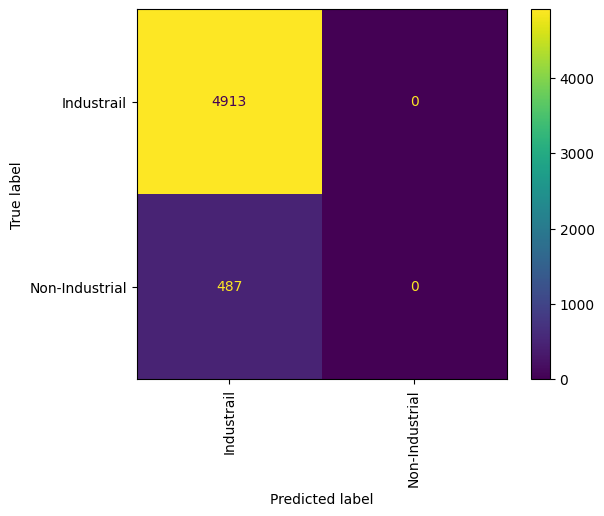

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval() #we're no longer training the model. Put it into "evaluate" mode (as opposed to "train" mode). This only affects some layers, like dropout.
test_predictions = []
test_labels = []
with torch.no_grad():
    for X,y in test_dataloader:
        X.to(device)
        test_predictions += [model(X.to(device)).squeeze(1) >= 0.0] #changed to sigmoid
        test_labels += [(y==4)]
test_predictions = torch.cat(test_predictions)
test_labels = torch.cat(test_labels)

c_mat = confusion_matrix(test_labels, test_predictions.cpu()) #move the predictions from the gpu to the cpu, if they're on a gpu
ConfusionMatrixDisplay(c_mat, display_labels=["Industrail","Non-Industrial"]).plot(xticks_rotation='vertical')
